In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
autism_screening_adult = fetch_ucirepo(id=426)

# data (as pandas dataframes)
X = autism_screening_adult.data.features
y = autism_screening_adult.data.targets

# metadata
print(autism_screening_adult.metadata)

# variable information
print(autism_screening_adult.variables)

{'uci_id': 426, 'name': 'Autism Screening Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/426/autism+screening+adult', 'data_url': 'https://archive.ics.uci.edu/static/public/426/data.csv', 'abstract': 'Autistic Spectrum Disorder Screening Data for Adult. This dataset is related to classification and predictive tasks.', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': [], 'num_instances': 704, 'num_features': 20, 'feature_types': ['Integer'], 'demographics': ['Age', 'Gender', 'Ethnicity', 'Nationality'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2017, 'last_updated': 'Thu Mar 28 2024', 'dataset_doi': '10.24432/C5F019', 'creators': ['Fadi Thabtah'], 'intro_paper': None, 'additional_info': {'summary': "See attached variables' description file ", 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset
data_url = "https://archive.ics.uci.edu/static/public/426/data.csv"
df = pd.read_csv(data_url)
df.columns = df.columns.str.strip()  # Remove any whitespace from column names

# Drop rows with missing target values (optional if target isn't used in clustering)
df = df.dropna(subset=['class'])

# Separate features from target variable for clustering
X = df.drop(columns=['class'])  # Exclude the target for unsupervised learning

# Define numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Column transformer to apply preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
X_processed = preprocessor.fit_transform(X)

# Apply K-Means clustering
n_clusters = 3  # Set number of clusters (can be adjusted)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_processed)
cluster_labels = kmeans.predict(X_processed)

# Evaluate the clustering with silhouette score
silhouette_avg = silhouette_score(X_processed, cluster_labels)
print("For n_clusters =", n_clusters, "The average silhouette score is :", silhouette_avg)

# Add the cluster labels to the original dataset
df['cluster'] = cluster_labels
print("\nSample of data with cluster labels:")
print(df[['class', 'cluster']].head(10))

For n_clusters = 3 The average silhouette score is : 0.11987944317942062

Sample of data with cluster labels:
  class  cluster
0    NO        2
1    NO        2
2   YES        1
3    NO        2
4    NO        0
5   YES        1
6    NO        0
7    NO        0
8    NO        2
9   YES        1


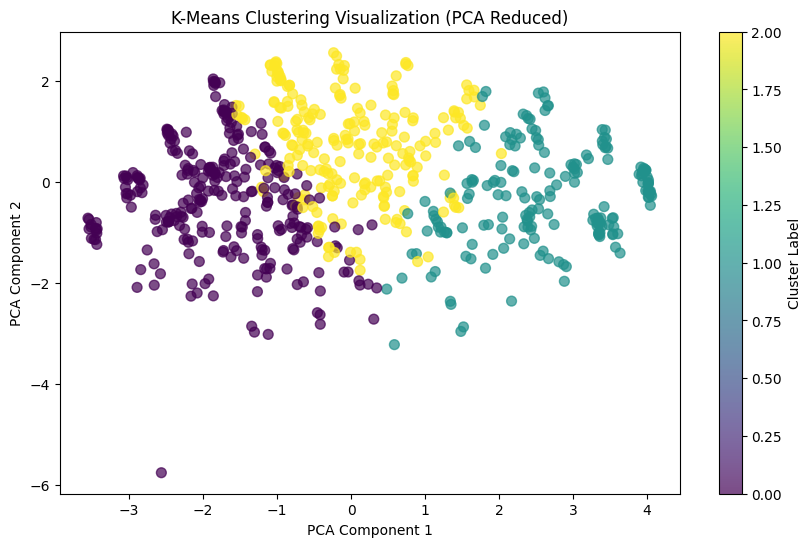

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(scatter, label='Cluster Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering Visualization (PCA Reduced)')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report

def create_model_pipeline(df):
    # 1. Split the data
    X = df.drop(columns=['class'])
    y = df['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 2. Define numeric and categorical features
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # 3. Create preprocessing pipeline
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])


    # 4. Create a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # 5. Preprocess data and apply SMOTE outside the pipeline
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # 6. Train a RandomForest model on resampled data
    classifier = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )

    classifier.fit(X_train_res, y_train_res)
    y_pred = classifier.predict(X_test)

    # 7. Print evaluation metrics
    print("\nModel Performance Evaluation:")
    print("-" * 30)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

    # 8. Feature importance (for interpretability)
    feature_names = list(numeric_features) + list(preprocessor.transformers_[1][1]
                                                  .named_steps['onehot']
                                                  .get_feature_names_out(categorical_features))

    importances = classifier.feature_importances_
    feature_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_imp = feature_imp.sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_imp.head(10))

    return classifier, X_test, y_test

# Load dataset and run pipeline
data_url = "https://archive.ics.uci.edu/static/public/426/data.csv"
df = pd.read_csv(data_url)
df.columns = df.columns.str.strip()  # Remove any whitespace from column names
pipeline, X_test, y_test = create_model_pipeline(df)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Model Performance Evaluation:
------------------------------
Accuracy: 1.0

Detailed Classification Report:
              precision    recall  f1-score   support

          NO       1.00      1.00      1.00       105
         YES       1.00      1.00      1.00        36

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141


Top 10 Most Important Features:
      feature  importance
11     result    0.311923
8    A9_Score    0.117465
5    A6_Score    0.101112
4    A5_Score    0.079844
3    A4_Score    0.059863
2    A3_Score    0.059016
9   A10_Score    0.035221
6    A7_Score    0.035201
1    A2_Score    0.032140
0    A1_Score    0.031097


In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
data_url = "https://archive.ics.uci.edu/static/public/426/data.csv"
df = pd.read_csv(data_url)
df.columns = df.columns.str.strip()  # Strip any whitespace from column names

# Define features and target
X = df.drop(columns=['class'])
y = df['class']

# 1. Handle Missing Values
# Use Simple Imputer for simplicity
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing on features
X_preprocessed = preprocessor.fit_transform(X)

# 2. Data Resampling using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

# 3. Algorithm Selection and Tuning (Focusing only on Random Forest and SVM)
# Define and tune fewer models
params = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [20, 30]},
    'SVM': {'C': [1, 10], 'kernel': ['linear', 'rbf']}
}

classifiers = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True)
}

best_estimators = {}
for model_name, model in classifiers.items():
    clf = GridSearchCV(model, params[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_resampled, y_resampled)
    best_estimators[model_name] = clf.best_estimator_
    print(f"Best parameters for {model_name}: {clf.best_params_}")

# 4. Ensemble Method with Simplified Voting Classifier
voting_clf = VotingClassifier(
    estimators=[(name, best_estimators[name]) for name in best_estimators],
    voting='soft'
)

# Train the ensemble model
voting_clf.fit(X_resampled, y_resampled)

# Evaluate model on test data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
y_pred = voting_clf.predict(X_test)

print("Accuracy of ensemble model:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 100}
Best parameters for SVM: {'C': 1, 'kernel': 'linear'}
Accuracy of ensemble model: 1.0
Classification Report:
               precision    recall  f1-score   support

          NO       1.00      1.00      1.00        97
         YES       1.00      1.00      1.00       109

    accuracy                           1.00       206
   macro avg       1.00      1.00      1.00       206
weighted avg       1.00      1.00      1.00       206

Confusion Matrix:
 [[ 97   0]
 [  0 109]]


In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
data_url = "https://archive.ics.uci.edu/static/public/426/data.csv"
df = pd.read_csv(data_url)

# Inspect the dataset
print("Dataset head:\n", df.head())
print("Data info:\n", df.info())

# 1. Handle Missing Values
# Using Simple Imputer for categorical data and KNN Imputer for numerical features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

# Imputers for both numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessor for the entire data pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Strip any whitespace from column names
df.columns = df.columns.str.strip()

# Now verify that 'class' column is correctly loaded
print(df.columns)

# Re-run the code with 'class' as the target column
X = df.drop(columns=['class'])
y = df['class']


# 2. Feature Engineering
# Example of binning age if needed
# df['age_binned'] = pd.cut(df['age'], bins=[0, 18, 35, 50, np.inf], labels=['teen', 'young_adult', 'middle_aged', 'senior'])
# Define numeric_features and categorical_features after dropping 'class'
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessor for the entire data pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing on features
X_preprocessed = preprocessor.fit_transform(X)

# 3. Encoding Categorical Variables - Handled in the pipeline with OneHotEncoder above

# 4. Data Resampling using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

# 5. Algorithm Selection and Tuning
# Defining a set of algorithms and parameters for tuning
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'k-NN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression()
}

params = {
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30]},
    'Gradient Boosting': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 0.2]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'k-NN': {'n_neighbors': [3, 5, 7]},
    'Logistic Regression': {'C': [0.1, 1, 10]}
}

# Grid Search to find best parameters for each model
best_estimators = {}
for model_name, model in classifiers.items():
    clf = GridSearchCV(model, params[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_resampled, y_resampled)
    best_estimators[model_name] = clf.best_estimator_
    print(f"Best parameters for {model_name}: {clf.best_params_}")

# 6. Ensemble Methods
# Voting classifier with tuned models
voting_clf = VotingClassifier(
    estimators=[(name, best_estimators[name]) for name in best_estimators],
    voting='soft'
)

# Train the ensemble model
voting_clf.fit(X_resampled, y_resampled)

# Evaluate model on test data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
y_pred = voting_clf.predict(X_test)

print("Accuracy of ensemble model:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Dataset head:
    A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0         1         1         1         1         0         0         1   
1         1         1         0         1         0         0         0   
2         1         1         0         1         1         0         1   
3         1         1         0         1         0         0         1   
4         1         0         0         0         0         0         0   

   A8_Score  A9_Score  A10_Score  ...  gender       ethnicity jaundice  \
0         1         0          0  ...       f  White-European       no   
1         1         0          1  ...       m          Latino       no   
2         1         1          1  ...       m          Latino      yes   
3         1         0          1  ...       f  White-European       no   
4         1         0          0  ...       f             NaN       no   

  family_pdd   country_of_res used_app_before result       age_desc relation  \
0        

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
autistic_spectrum_disorder_screening_data_for_children = fetch_ucirepo(id=419)

# data (as pandas dataframes)
X = autistic_spectrum_disorder_screening_data_for_children.data.features
y = autistic_spectrum_disorder_screening_data_for_children.data.targets

# metadata
print(autistic_spectrum_disorder_screening_data_for_children.metadata)

# variable information
print(autistic_spectrum_disorder_screening_data_for_children.variables)

{'uci_id': 419, 'name': 'Autistic Spectrum Disorder Screening Data for Children  ', 'repository_url': 'https://archive.ics.uci.edu/dataset/419/autistic+spectrum+disorder+screening+data+for+children', 'data_url': 'https://archive.ics.uci.edu/static/public/419/data.csv', 'abstract': 'Children screening data for autism suitable for classification and predictive tasks ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 292, 'num_features': 20, 'feature_types': ['Integer'], 'demographics': ['\x00', 'Age', 'Gender', 'Ethnicity', 'Nationality'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2017, 'last_updated': 'Wed Apr 03 2024', 'dataset_doi': '10.24432/C5659W', 'creators': ['Fadi Thabtah'], 'intro_paper': None, 'additional_info': {'summary': "see attached file for variables' description ", 'purpose': None, 'funded_by': None, 'instances_repr

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fabdelja/autism-screening-for-toddlers")

print("Path to dataset files:", path)

100%|██████████| 53.2k/53.2k [00:00<00:00, 2.79MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/fabdelja/autism-screening-for-toddlers/versions/1


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/autism-screening-on-adults")

print("Path to dataset files:", path)

100%|██████████| 7.38k/7.38k [00:00<00:00, 6.18MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/autism-screening-on-adults/versions/1
